In [1]:
# necessary for when working with external scripts
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import nltk
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import plotly.plotly as py
import plotly.graph_objs as go
import math
%matplotlib inline

# my functions
import helpers.data_mining_helpers as dmh
import helpers.text_analysis as ta

## 2. Data Preparation

In [3]:
# categories
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

# obtain the documents containing the categories provided
twenty_train = fetch_20newsgroups(subset='train', categories=categories,shuffle=True, random_state=42)


## 3. So What's next?
### 3.1 Converting Dictionary into Pandas dataframe

In [4]:
twenty_train.data[0:2]
type(twenty_train.data)

list

In [5]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [6]:
len(twenty_train.filenames)

2257

In [7]:
len(twenty_train.data)

2257

In [8]:
# An example of what the subset contains
print("\n".join(twenty_train.data[0].split("\n")))

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.



In [9]:
print(twenty_train.target_names[twenty_train.target[0]])

comp.graphics


In [10]:
twenty_train.target[:10]

array([1, 1, 3, 3, 3, 3, 3, 2, 2, 2], dtype=int64)

In [11]:
for t in twenty_train.target[:50]:
    print(twenty_train.target_names[t])

comp.graphics
comp.graphics
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
sci.med
sci.med
sci.med
soc.religion.christian
comp.graphics
alt.atheism
alt.atheism
comp.graphics
comp.graphics
sci.med
alt.atheism
soc.religion.christian
alt.atheism
soc.religion.christian
alt.atheism
soc.religion.christian
comp.graphics
comp.graphics
comp.graphics
soc.religion.christian
soc.religion.christian
sci.med
sci.med
sci.med
soc.religion.christian
sci.med
soc.religion.christian
sci.med
soc.religion.christian
alt.atheism
alt.atheism
alt.atheism
comp.graphics
soc.religion.christian
alt.atheism
comp.graphics
comp.graphics
sci.med
alt.atheism
soc.religion.christian
soc.religion.christian
comp.graphics
sci.med


In [12]:
twenty_train.target

array([1, 1, 3, ..., 2, 2, 2], dtype=int64)

In [13]:
print(type(dmh.format_rows(twenty_train)))
print(type(twenty_train))
#pd.DataFrame.from_records: input a ndarray, list, tuple, dict or DataFrame to get DataFrame
X = pd.DataFrame.from_records(dmh.format_rows(twenty_train), columns= ['text'])
len(X)
print(type(X.text))

<class 'list'>
<class 'sklearn.datasets.base.Bunch'>
<class 'pandas.core.series.Series'>


In [14]:
X[0:2]

,text
0,From: sd345@city.ac.uk (Michael Collier) Subje...
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...


In [15]:
X.index  #資料只到stop的前一個，stop值並沒有內容

RangeIndex(start=0, stop=2257, step=1)

In [16]:
# add category to the dataframe
X['category'] = twenty_train.target

In [17]:
# add category label also
X['category_name'] = X.category.apply(lambda t: dmh.format_labels(t, twenty_train))

In [18]:
X[0:10]

,text,category,category_name
0,From: sd345@city.ac.uk (Michael Collier) Subje...,1,comp.graphics
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...,1,comp.graphics
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,3,soc.religion.christian
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,3,soc.religion.christian
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3,soc.religion.christian
5,From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...,3,soc.religion.christian
6,From: jodfishe@silver.ucs.indiana.edu (joseph ...,3,soc.religion.christian
7,From: aldridge@netcom.com (Jacquelin Aldridge)...,2,sci.med
8,From: geb@cs.pitt.edu (Gordon Banks) Subject: ...,2,sci.med
9,From: libman@hsc.usc.edu (Marlena Libman) Subj...,2,sci.med


### 3.2 Familiarizing yourself with the Data

In [19]:
X[0:10][["text", "category_name"]]

,text,category_name
0,From: sd345@city.ac.uk (Michael Collier) Subje...,comp.graphics
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...,comp.graphics
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,soc.religion.christian
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,soc.religion.christian
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,soc.religion.christian
5,From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...,soc.religion.christian
6,From: jodfishe@silver.ucs.indiana.edu (joseph ...,soc.religion.christian
7,From: aldridge@netcom.com (Jacquelin Aldridge)...,sci.med
8,From: geb@cs.pitt.edu (Gordon Banks) Subject: ...,sci.med
9,From: libman@hsc.usc.edu (Marlena Libman) Subj...,sci.med


In [20]:
X[-11:-1]

,text,category,category_name
2246,From: lmvec@westminster.ac.uk (William Hargrea...,3,soc.religion.christian
2247,From: daniels@math.ufl.edu (TV's Big Dealer) S...,3,soc.religion.christian
2248,"From: ""danny hawrysio"" <danny.hawrysio@canrem....",1,comp.graphics
2249,From: shellgate!llo@uu4.psi.com (Larry L. Over...,3,soc.religion.christian
2250,From: ingles@engin.umich.edu (Ray Ingles) Subj...,0,alt.atheism
2251,From: Mark-Tarbell@suite.com Subject: Amniocen...,2,sci.med
2252,From: roos@Operoni.Helsinki.FI (Christophe Roo...,2,sci.med
2253,From: mhollowa@ic.sunysb.edu (Michael Holloway...,2,sci.med
2254,From: sasghm@theseus.unx.sas.com (Gary Merrill...,2,sci.med
2255,From: Dan Wallach <dwallach@cs.berkeley.edu> S...,2,sci.med


In [21]:
X.iloc[::10,:][0:10]

,text,category,category_name
0,From: sd345@city.ac.uk (Michael Collier) Subje...,1,comp.graphics
10,From: anasaz!karl@anasazi.com (Karl Dussik) Su...,3,soc.religion.christian
20,From: dotsonm@dmapub.dma.org (Mark Dotson) Sub...,3,soc.religion.christian
30,From: vgwlu@dunsell.calgary.chevron.com (greg ...,2,sci.med
40,From: david-s@hsr.no (David A. Sjoen) Subject:...,3,soc.religion.christian
50,From: ab@nova.cc.purdue.edu (Allen B) Subject:...,1,comp.graphics
60,From: Nanci Ann Miller <nm0w+@andrew.cmu.edu> ...,0,alt.atheism
70,From: weaver@chdasic.sps.mot.com (Dave Weaver)...,3,soc.religion.christian
80,From: annick@cortex.physiol.su.oz.au (Annick A...,2,sci.med
90,Subject: Vonnegut/atheism From: dmn@kepler.unh...,0,alt.atheism


####  Exercise 0  
```python
#this is the same with iloc when the index is a sequence start from 0
X.loc[::10,:][0:10] 

#this supports mixed integer and label based access 
#can decide to index positionally OR via labels depending on the data type of the index.
X.ix[::10,['text','category','category_name']][0:10]
```

## 4.Data Mining using Pandas
### 4.1 Missing Values

In [22]:
X.isnull()

,text,category,category_name
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
5,False,False,False
6,False,False,False
7,False,False,False
8,False,False,False
9,False,False,False


In [23]:
X.isnull().apply(lambda x: dmh.check_missing_values(x),axis=0)
#apply: Objects passed to functions are Series objects having index either the DataFrame’s index (axis=0) 
#        or the columns (axis=1).

text             (The amoung of missing records is: , 0)
category         (The amoung of missing records is: , 0)
category_name    (The amoung of missing records is: , 0)
dtype: object

#### *Details of apply function

```python
import pandas as pd
import numpy as np
df = {'one' : pd.Series([1., 2., 3.], index=['a', 'b', 'c']),'two' : pd.Series([1., 2., 3., 4.], index=['a', 'b', 'c', 'd'])}
df = pd.DataFrame(df)
df.isnull().apply(np.sum, axis=0)
df.apply(np.sqrt) # returns DataFrame
df.apply(np.sum, axis=0) # equiv to df.sum(0)
df.apply(np.sum, axis=1) # equiv to df.sum(1)
```

####  Exercise 1
```python
X.isnull().apply(lambda x: dmh.check_missing_values(x),axis=1)
```

In [24]:
dummy_series = pd.Series(["dummy_record", 1], index=["text", "category"])

In [25]:
dummy_series

text        dummy_record
category               1
dtype: object

In [26]:
result_with_series = X.append(dummy_series, ignore_index=True)

In [27]:
# check if the records was commited into result
len(result_with_series)

2258

In [28]:
result_with_series.isnull().apply(lambda x: dmh.check_missing_values(x))

text             (The amoung of missing records is: , 0)
category         (The amoung of missing records is: , 0)
category_name    (The amoung of missing records is: , 1)
dtype: object

In [29]:
dummy_dict = [{'text': 'dummy_record', 'category': 1 }]

In [30]:
len(X)

2257

In [31]:
X = X.append(dummy_dict,ignore_index=True)

In [32]:
len(X)

2258

In [33]:
X.isnull().apply(lambda x: dmh.check_missing_values(x))

text             (The amoung of missing records is: , 0)
category         (The amoung of missing records is: , 0)
category_name    (The amoung of missing records is: , 1)
dtype: object

In [34]:
X.dropna(inplace=True)

In [35]:
X.isnull().apply(lambda x: dmh.check_missing_values(x))

text             (The amoung of missing records is: , 0)
category         (The amoung of missing records is: , 0)
category_name    (The amoung of missing records is: , 0)
dtype: object

### 4.2 Dealing with Duplicate Data

In [36]:
#X.duplicated()

In [37]:
sum(X.duplicated())

0

In [38]:
dummy_duplicate_dict = [{
                             'text': 'dummy record',
                             'category': 1, 
                             'category_name': "dummy category"
                        },
                        {
                             'text': 'dummy record',
                             'category': 1, 
                             'category_name': "dummy category"
                        }]

In [39]:
X = X.append(dummy_duplicate_dict, ignore_index=True)

In [40]:
len(X)

2259

In [41]:
sum(X.duplicated('text'))

1

In [42]:
X.drop_duplicates(keep=False, inplace=True)

In [43]:
len(X)

2257

## 5. Data Preprocessing
### 5.1 Sampling

In [44]:
X_sample = X.sample(n=1000)

In [45]:
len(X_sample)

1000

In [46]:
X_sample[0:4]

,text,category,category_name
1067,From: bernard@cs.su.oz.au (Bernard Gardner) Su...,1,comp.graphics
1425,From: bil@okcforum.osrhe.edu (Bill Conner) Sub...,0,alt.atheism
1363,From: db7n+@andrew.cmu.edu (D. Andrew Byler) S...,3,soc.religion.christian
5,From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...,3,soc.religion.christian


In [47]:
X_category_counts = ta.get_tokens_and_frequency(list(X.category_name))
X_sample_category_counts = ta.get_tokens_and_frequency(list(X_sample.category_name))

#print(X_category_counts)
#print(X_category_counts[0])
#print(X_category_counts[1])

In [48]:
#py.iplot(ta.plot_word_frequency(X_category_counts, "Category distribution"))
#py.plot(ta.plot_word_frequency(X_sample_category_counts, "Category distribution"))


####  Exercise 2  
```python
import matplotlib.pyplot as plt
# Setting the positions and width for the bars
pos = list(range(4)) 
width = 0.25 

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, X.category_name.value_counts(), width, alpha=0.8,
        color='g',label='Original data set') 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos],X_sample.category_name.value_counts(), width, alpha=0.8,
        color='midnightblue',label='Sample data set') 

# Set the y axis label
ax.set_ylabel('Count')

# Set the chart's title
ax.set_title('Category distribution')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(X.category_name.value_counts().index)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 630])

# Adding the legend and showing the plot
plt.legend(['Original', 'Saampling'], loc='upper right')
plt.grid()
plt.show()
```

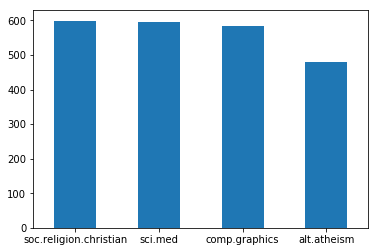

In [49]:
X.category_name.value_counts().plot(kind="bar", rot=0)

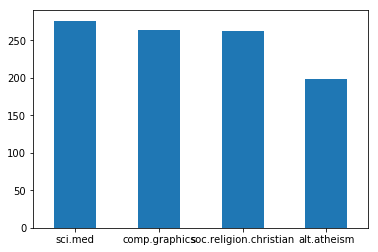

In [50]:
X_sample.category_name.value_counts().plot(kind="bar", rot=0)

### 5.2 Feature Creation

*Deatails/examples of nltk.sent_tokenize and nltk.word_tokenize
```python
text = "this’s a sent tokenize test. this is sent two. is this sent three? sent 4 is cool! Now it’s your turn."
from nltk.tokenize import sent_tokenize
sent_tokenize_list = sent_tokenize(text)
print(sent_tokenize_list)  #cut into sentences

from nltk.tokenize import word_tokenize
for d in sent_tokenize_list:
  a=word_tokenize(d, language='english')
  print(a) #cut into words

```

In [51]:
X['text'][0:1].apply(lambda x: dmh.tokenize_text(x))

0    [From, :, sd345, @, city.ac.uk, (, Michael, Co...
Name: text, dtype: object

In [52]:
import nltk
#nltk.download()
# takes a like a minute or two to process
X['unigrams'] = X['text'].apply(lambda x: dmh.tokenize_text(x))

In [53]:
X[0:4]["unigrams"]

0    [From, :, sd345, @, city.ac.uk, (, Michael, Co...
1    [From, :, ani, @, ms.uky.edu, (, Aniruddha, B....
2    [From, :, djohnson, @, cs.ucsd.edu, (, Darin, ...
3    [From, :, s0612596, @, let.rug.nl, (, M.M, ., ...
Name: unigrams, dtype: object

In [54]:
list(X[0:1]['unigrams'])

[['From',
  ':',
  'sd345',
  '@',
  'city.ac.uk',
  '(',
  'Michael',
  'Collier',
  ')',
  'Subject',
  ':',
  'Converting',
  'images',
  'to',
  'HP',
  'LaserJet',
  'III',
  '?',
  'Nntp-Posting-Host',
  ':',
  'hampton',
  'Organization',
  ':',
  'The',
  'City',
  'University',
  'Lines',
  ':',
  '14',
  'Does',
  'anyone',
  'know',
  'of',
  'a',
  'good',
  'way',
  '(',
  'standard',
  'PC',
  'application/PD',
  'utility',
  ')',
  'to',
  'convert',
  'tif/img/tga',
  'files',
  'into',
  'LaserJet',
  'III',
  'format',
  '.',
  'We',
  'would',
  'also',
  'like',
  'to',
  'do',
  'the',
  'same',
  ',',
  'converting',
  'to',
  'HPGL',
  '(',
  'HP',
  'plotter',
  ')',
  'files',
  '.',
  'Please',
  'email',
  'any',
  'response',
  '.',
  'Is',
  'this',
  'the',
  'correct',
  'group',
  '?',
  'Thanks',
  'in',
  'advance',
  '.',
  'Michael',
  '.',
  '--',
  'Michael',
  'Collier',
  '(',
  'Programmer',
  ')',
  'The',
  'Computer',
  'Unit',
  ',',
  'Emai

### 5.3 Feature subset selection

In [55]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X.text)  #取句子中不重複的值，會去掉標點或符號,即get_feature_names()的長度
print(X_counts.shape)#count_vect.get_feature_names()

(2257, 35788)


In [56]:
analyze = count_vect.build_analyzer()
analyze(" ".join(list(X[4:5].text))) 

['from',
 'stanly',
 'grok11',
 'columbiasc',
 'ncr',
 'com',
 'stanly',
 'subject',
 're',
 'elder',
 'brother',
 'organization',
 'ncr',
 'corp',
 'columbia',
 'sc',
 'lines',
 '15',
 'in',
 'article',
 'apr',
 '00',
 '57',
 '41',
 '1993',
 '28246',
 'athos',
 'rutgers',
 'edu',
 'rexlex',
 'fnal',
 'gov',
 'writes',
 'in',
 'article',
 'apr',
 '01',
 '56',
 '56',
 '1993',
 '22824',
 'athos',
 'rutgers',
 'edu',
 'shrum',
 'hpfcso',
 'fc',
 'hp',
 'com',
 'matt',
 '22',
 '14',
 'go',
 'therefore',
 'to',
 'the',
 'main',
 'highways',
 'and',
 'as',
 'many',
 'as',
 'you',
 'find',
 'there',
 'invite',
 'to',
 'the',
 'wedding',
 'feast',
 'hmmmmmm',
 'sounds',
 'like',
 'your',
 'theology',
 'and',
 'christ',
 'are',
 'at',
 'odds',
 'which',
 'one',
 'am',
 'to',
 'believe',
 'in',
 'this',
 'parable',
 'jesus',
 'tells',
 'the',
 'parable',
 'of',
 'the',
 'wedding',
 'feast',
 'the',
 'kingdom',
 'of',
 'heaven',
 'is',
 'like',
 'unto',
 'certain',
 'king',
 'which',
 'made',
 'm

In [57]:
len(" ".join(list(X[4:5].text)))

966

In [58]:
# We can check the shape of this matrix by:
X_counts.shape

(2257, 35788)

In [59]:
# We can obtain the feature names of the vectorizer, i.e., the terms
count_vect.get_feature_names()[0:10]

['00',
 '000',
 '0000',
 '0000001200',
 '000005102000',
 '0001',
 '000100255pixel',
 '00014',
 '000406',
 '0007']

In [60]:
X[0:5]

,text,category,category_name,unigrams
0,From: sd345@city.ac.uk (Michael Collier) Subje...,1,comp.graphics,"[From, :, sd345, @, city.ac.uk, (, Michael, Co..."
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...,1,comp.graphics,"[From, :, ani, @, ms.uky.edu, (, Aniruddha, B...."
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,3,soc.religion.christian,"[From, :, djohnson, @, cs.ucsd.edu, (, Darin, ..."
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,3,soc.religion.christian,"[From, :, s0612596, @, let.rug.nl, (, M.M, ., ..."
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3,soc.religion.christian,"[From, :, stanly, @, grok11.columbiasc.ncr.com..."


In [61]:
X_counts[0:5,0:100].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [62]:
count_vect.transform(['Something completely new.']).toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [63]:
count_vect.transform(['0000=Something completely new.']).toarray()

array([[0, 0, 1, ..., 0, 0, 0]], dtype=int64)

In [64]:
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names()[0:20]]
print(plot_x)

['term_00', 'term_000', 'term_0000', 'term_0000001200', 'term_000005102000', 'term_0001', 'term_000100255pixel', 'term_00014', 'term_000406', 'term_0007', 'term_000usd', 'term_0010', 'term_001004', 'term_0010580b', 'term_001125', 'term_001200201pixel', 'term_0014', 'term_001642', 'term_00196', 'term_002']


In [65]:
plot_y = ["doc_"+ str(i) for i in list(X.index)[0:20]]
print(plot_y)

['doc_0', 'doc_1', 'doc_2', 'doc_3', 'doc_4', 'doc_5', 'doc_6', 'doc_7', 'doc_8', 'doc_9', 'doc_10', 'doc_11', 'doc_12', 'doc_13', 'doc_14', 'doc_15', 'doc_16', 'doc_17', 'doc_18', 'doc_19']


In [66]:
plot_z = X_counts[0:20, 0:20].toarray()
print(plot_z)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


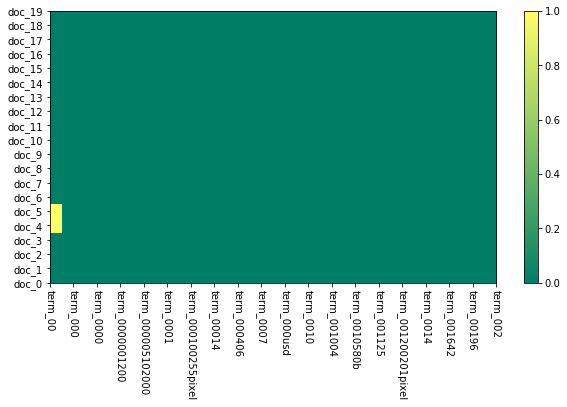

In [67]:
# to plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
plt.axis([0, 19, 0, 19])
plt.xticks(range(20),plot_x,rotation=270)
plt.yticks(range(20),plot_y,rotation=0)
ax.imshow(plot_z,cmap="summer")
plt.colorbar(ax.imshow(plot_z,cmap="summer"))
ax.set_aspect('auto')
plt.show()

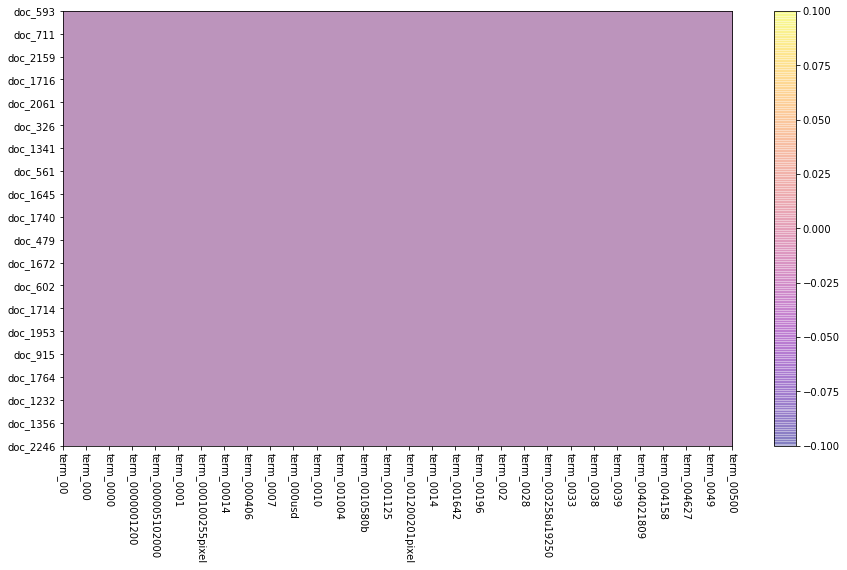

In [68]:
### Exercise 3
import random as rd
rd.seed(123)
X_sample_20=X.sample(n=20)
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names()[0:30]]
plot_y = ["doc_"+ str(i) for i in list(X_sample_20.index)]

plot_z =count_vect.transform(X_sample_20.text)[:,0:30].toarray()
#print(len(count_vect.get_feature_names()))
#print(X_sample_50_counts.toarray().shape)
#print(plot_x)
#print(len(plot_y))
#print(plot_z.shape)
fig, ax = plt.subplots(figsize=(15, 8))
plt.axis([0, 29, 0, 19])
plt.xticks(range(30),plot_x,rotation=270)
plt.yticks(range(20),plot_y,rotation=0)
ax.imshow(plot_z,cmap="plasma",alpha=0.3)
plt.colorbar(ax.imshow(plot_z,cmap="plasma",alpha=0.3))
ax.set_aspect('auto')
plt.show()

### 5.4 Dimensionality Reduction

In [69]:
from sklearn.decomposition import PCA

In [70]:
X_reduced = PCA(n_components=3).fit_transform(X_counts.toarray())

In [71]:
X_reduced

array([[ -17.01172954,    0.45016639,   -1.31226071],
       [  -6.80574586,   -1.15880602,   -0.40488277],
       [  15.79461065,    3.622331  ,   12.70799072],
       ..., 
       [  19.97508176,   -2.85495809,    1.04076601],
       [ 163.88523745,   29.52467802,   -8.70178689],
       [ -16.58569528,    0.61748553,   -1.88007229]])

In [72]:
categories

['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

In [73]:
trace1 = ta.get_trace(X_reduced, X["category_name"], "alt.atheism", "rgb(71,233,163)")
trace2 = ta.get_trace(X_reduced, X["category_name"], "soc.religion.christian", "rgb(52,133,252)")
trace3 = ta.get_trace(X_reduced, X["category_name"], "comp.graphics", "rgb(229,65,136)")
trace4 = ta.get_trace(X_reduced, X["category_name"], "sci.med", "rgb(99,151,68)")
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='simple-3d-scatter')

In [74]:
pc_1=X_reduced.T[0][:, np.newaxis]
pc_2=X_reduced.T[1][:, np.newaxis]
pc_3=X_reduced.T[2][:, np.newaxis]
#print(len(pc_1[X["category_name"]=='alt.atheism']))
#print(len(pc_1[X["category_name"]=='soc.religion.christian']))
#print(pc_3[X["category_name"]=='comp.graphics'])
#print(len(pc_1[X["category_name"]=='sci.med']))

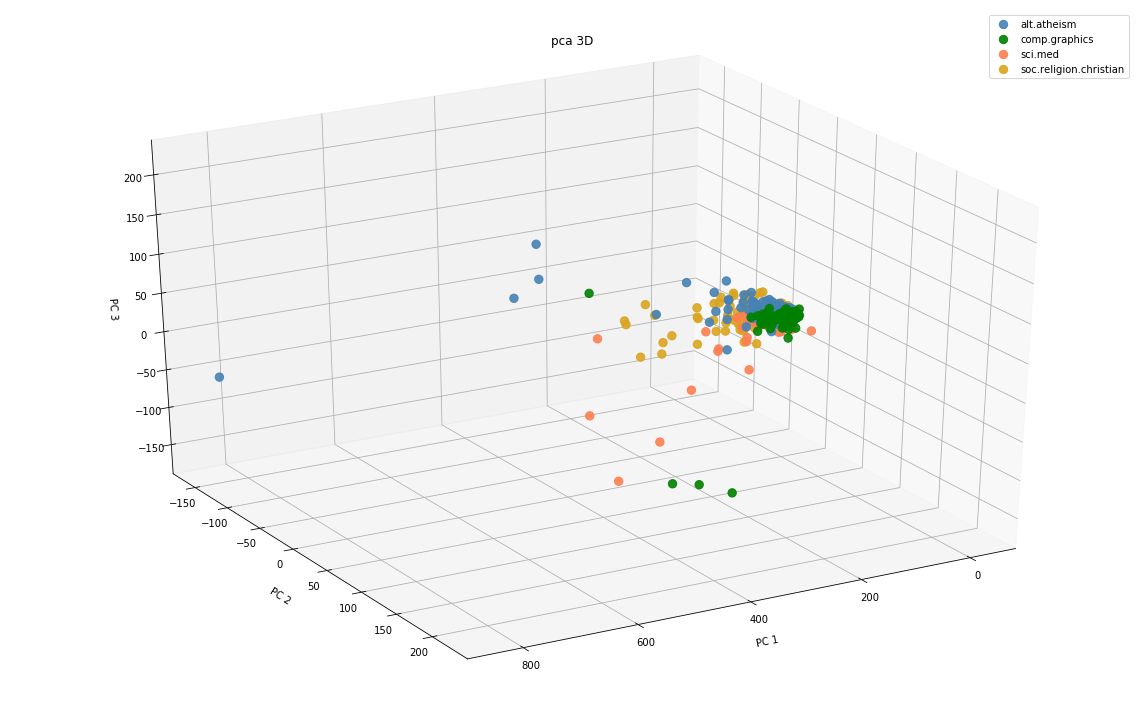

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
#plot 3D
colors = ['steelblue','green','coral','goldenrod']
fig = plt.figure(figsize=(16,10))

plt3d = fig.add_subplot(1,1,1, projection='3d')

for l, c in zip(np.unique(X["category_name"]), colors):
    plt3d.scatter(pc_1[X["category_name"]==l],
                  pc_2[X["category_name"]==l],
                  pc_3[X["category_name"]==l],
                  c=c, label=l, marker='o', alpha=0.9, s=70)

plt.title('pca 3D\n')
plt.xlabel('\n\nPC 1');plt.ylabel('\n\nPC 2')
plt3d.set_zlabel('\nPC 3')
plt.legend(loc='upper right')
plt.tight_layout()
plt3d.azim = 60
ax.elev = -5
plt3d.set_aspect('auto')
plt.show()

### 5.5 Atrribute Transformation / Aggregation

In [ ]:
# note this takes time to compute. You may want to reduce the amount of terms you want to compute frequencies for
term_frequencies = []

for j in range(0,X_counts.shape[1]):
    term_frequencies.append(sum(X_counts[:,j].toarray()))

In [ ]:
term_frequencies[0]

In [ ]:
#py.iplot(ta.plot_word_frequency([count_vect.get_feature_names(), term_frequencies], "Term Frequency Distribution"))

#py.iplot(ta.plot_word_frequency([count_vect.get_feature_names(), term_frequencies], "Term Frequency Distribution"))
fig, ax = plt.subplots(figsize=(20,5))

plt.bar(range(0,X_counts.shape[1]),term_frequencies, alpha=0.8, color='steelblue') 
plt.xticks(range(0,X_counts.shape[1]),count_vect.get_feature_names(),rotation=270,fontsize=10)
ax.set_ylabel('Count')
ax.set_title('Term Frequency Distribution')

plt.grid()
plt.show()

Exercise 4
```python
fig, ax = plt.subplots(figsize=(40,10))
plt.bar(range(0,100),term_frequencies[0:100], alpha=0.8, color='steelblue') 
plt.xticks(range(0,100),count_vect.get_feature_names()[0:100],rotation=270,fontsize=18)
ax.set_ylabel('Count')
ax.set_title('Term Frequency Distribution')

plt.grid()
plt.show()
```

Exercise 5
```python
term_frequencies_sort_idx=sorted(range(len(term_frequencies)),reverse=True, key=lambda k: term_frequencies[k])
term_frequencies_top=list( term_frequencies[i] for i in term_frequencies_sort_idx[0:50] )
term_name_top=list( count_vect.get_feature_names()[i] for i in term_frequencies_sort_idx[0:50] )

fig, ax = plt.subplots(figsize=(40,10))
plt.bar(range(0,50),term_frequencies_top, alpha=0.8, color='steelblue') 
plt.xticks(range(0,50),term_name_top,rotation=90,fontsize=25)
plt.yticks(fontsize=20)
ax.set_ylabel('Count',fontsize=30)
ax.set_title('Term Frequency Distribution',fontsize=30)

plt.grid()
plt.show()
```

In [ ]:
term_frequencies_log = [math.log(i) for i in term_frequencies]

In [ ]:
#py.iplot(ta.plot_word_frequency([count_vect.get_feature_names(), term_frequencies_log], "Term Frequency Distribution"))

### 5.6 Discretization and Binarization

In [ ]:
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy

In [ ]:
mlb = preprocessing.LabelBinarizer()

In [ ]:
mlb.fit(X.category)

In [ ]:
mlb.classes_

In [ ]:
X['bin_category'] = mlb.transform(X['category']).tolist()

In [ ]:
X[0:9]